<a href="https://colab.research.google.com/github/patrickclaveaustudents/assignment2.ipynb/blob/main/Assignment_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignement 14 Patrick Claveau

In [4]:
!pip install fairlearn shap lime

from fairlearn.datasets import fetch_adult
import pandas as pd

# Load dataset
X_raw, y_raw = fetch_adult(as_frame=True, return_X_y=True)
df = X_raw.copy()
df['target'] = y_raw
df.head()



,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
df = df.dropna()
df['target'] = df['target'].apply(lambda x: 1 if x == '>50K' else 0)

# Save sensitive feature separately
sensitive_feature = df['sex']

# One-hot encode categorical variables
X = pd.get_dummies(df.drop(columns='target'), drop_first=True)
y = df['target']


/tmp/ipython-input-5-1258034051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].apply(lambda x: 1 if x == '>50K' else 0)


 Model Training and Evaluation

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)https://chatgpt.com/c/685b4b94-db14-8009-9912-e2b59734f422
y_pred = model.predict(X_test)


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8402432283029297
Confusion Matrix:
 [[6298  505]
 [ 940 1302]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      6803
           1       0.72      0.58      0.64      2242

    accuracy                           0.84      9045
   macro avg       0.80      0.75      0.77      9045
weighted avg       0.83      0.84      0.83      9045



Fairness Analysis

In [8]:
!pip install fairlearn

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
    'true_positive_rate': true_positive_rate
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature.loc[X_test.index]
)

print(metric_frame.by_group)


        accuracy  selection_rate  false_positive_rate  true_positive_rate
sex                                                                      
Female  0.912611        0.086361              0.02818            0.495868
Male    0.805778        0.253795              0.10193            0.597126


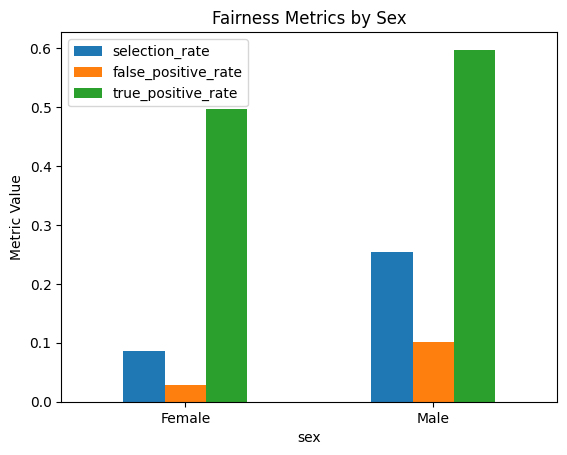

In [9]:
import matplotlib.pyplot as plt

metric_frame.by_group[["selection_rate", "false_positive_rate", "true_positive_rate"]].plot.bar()
plt.title("Fairness Metrics by Sex")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.show()


Explainability Analysis

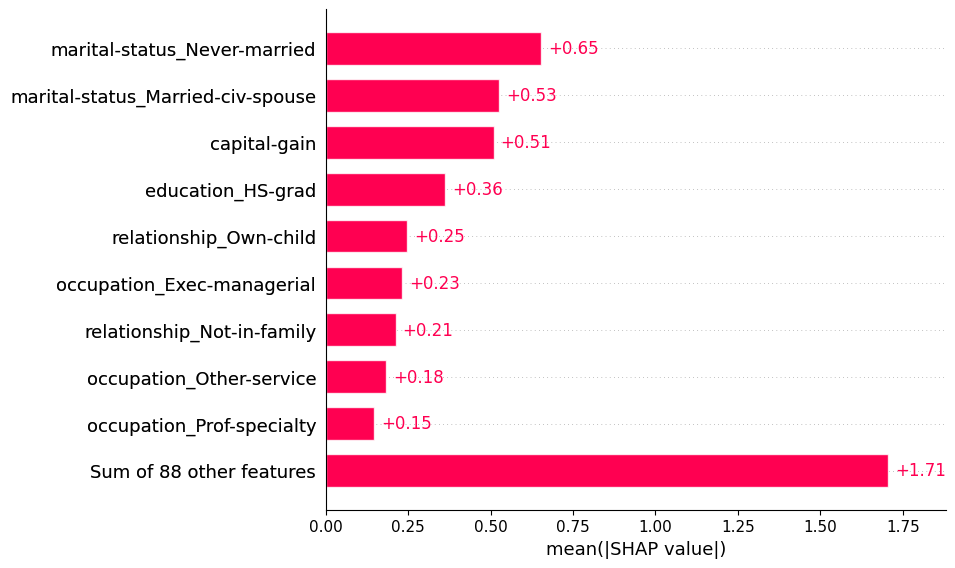

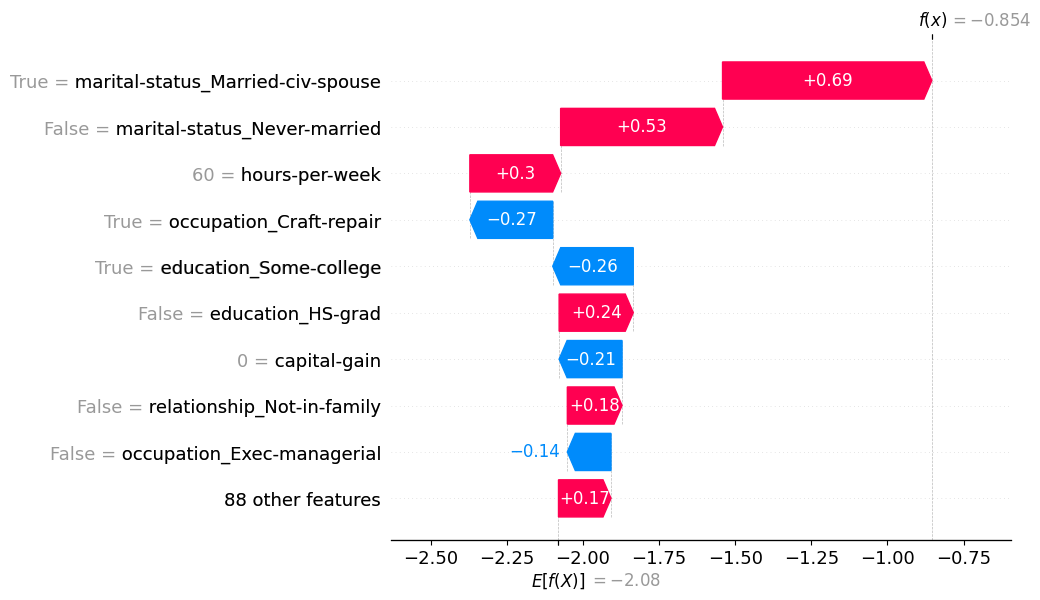

In [10]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Global
shap.plots.bar(shap_values)

# Local
shap.plots.waterfall(shap_values[0])



Explainability Analysis

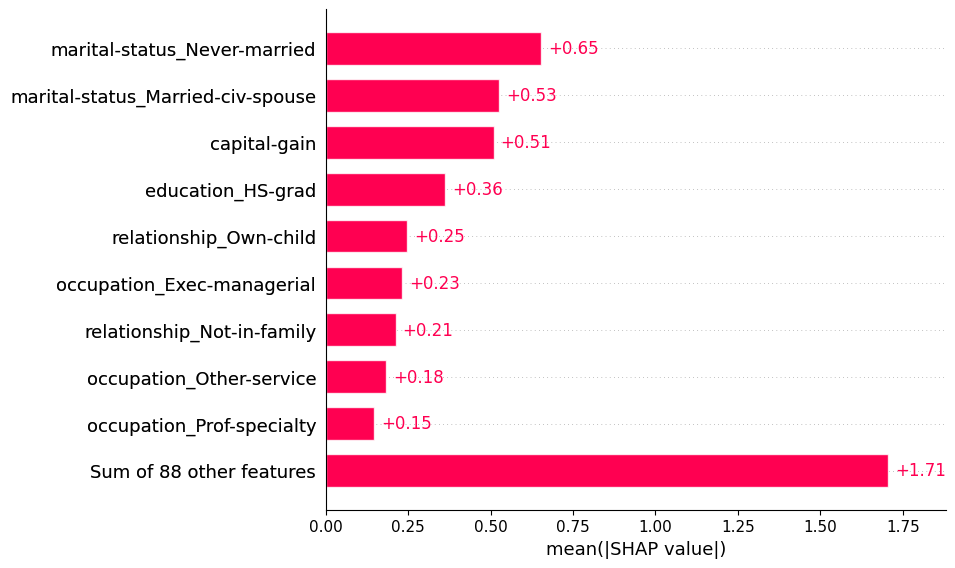

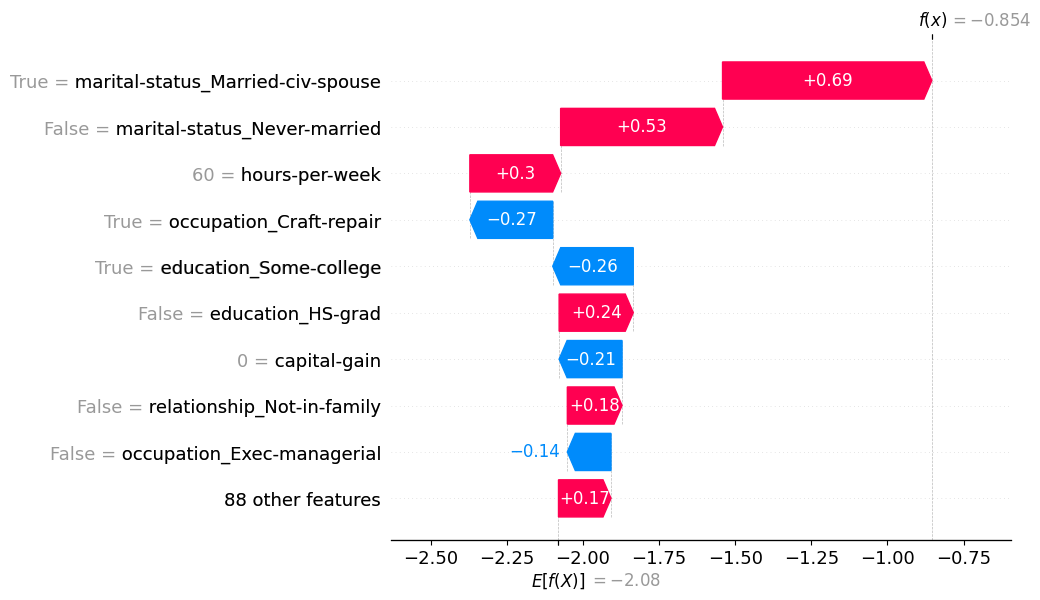

In [11]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Global
shap.plots.bar(shap_values)

# Local
shap.plots.waterfall(shap_values[0])


In [12]:
import lime.lime_tabular

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['<=50K', '>50K'],
    mode='classification'
)

exp = explainer_lime.explain_instance(X_test.values[0], model.predict_proba)
exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
